# ruiyi data structure

a notebook to play with ruiyi's data structure

## basic preparetion

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('../../privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])

In [3]:
sys.path.append(os.path.abspath(workdir))
sys.path.append(os.path.abspath(workdir/'test'))
# os.chdir(workdir/'test/neural')
os.chdir(workdir)

In [4]:
# imports

from sklearn.model_selection import cross_val_predict, cross_val_score
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt
from firefly_utils.data_handler import data_handler
from firefly_utils.behav_class import *
from scipy.io import loadmat
import pickle
import pandas as pd
from numpy.lib.npyio import save
from cmaes import CMA
import matplotlib.pyplot as plt
from InverseFuncs import *
from monkey_functions import *
from notification import notify
from sklearn import linear_model
from plot_ult import *
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.pipeline import make_pipeline
from scipy.stats import pearsonr
from pingouin import partial_corr
from scipy.ndimage import gaussian_filter1d

## setting some constants

In [5]:
# const

bin_size = 17 # how many bin of DT. about 0.1 s
num_bins = 24 # how many bins to use. use 2.4 s and discard the long trials.
monkey_height = 10
DT = 0.006 # DT for raw data
reward_boundary = 65
areas = ['PPC', 'PFC', 'MST']
m_extracted_continuous = {}; m_downsampled = {}; m_errors = {}

m = 'm53'
locals().update({m: {}})

figure_path = resdir/'figures'



In [6]:
# helper functions

def set_violin_plot(vp, facecolor, edgecolor, linewidth=1, alpha=1, ls='-', hatch=r''):
    plt.setp(vp['bodies'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha ,ls=ls, hatch=hatch)
    plt.setp(vp['cmins'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha)
    plt.setp(vp['cmaxes'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha)
    plt.setp(vp['cbars'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha)
    
    linecolor = 'k' if facecolor == 'None' else 'snow'
    if 'cmedians' in vp:
        plt.setp(vp['cmedians'], facecolor=linecolor, edgecolor=linecolor, 
                 linewidth=linewidth, alpha=alpha)
    if 'cmeans' in vp:
        plt.setp(vp['cmeans'], facecolor=linecolor, edgecolor=linecolor, 
                 linewidth=linewidth, alpha=alpha)
       
        
def downsample(data, bin_size=20):
    num_bin = data.shape[0] // bin_size
    data_ = data[:bin_size * num_bin]
    data_ = data_.reshape(num_bin, bin_size, data.shape[-1])
    data_ = np.nanmean(data_, axis=1)
    return data_


def convert_location_to_angle(gaze_r, gaze_x, gaze_y, body_theta, body_x, body_y, hor_theta_eye, ver_theta_eye):
    #hor_theta = -np.rad2deg(np.arctan2(-(gaze_x - body_x), gaze_y - body_y) - (body_theta-np.deg2rad(90))).reshape(-1, 1) 
    hor_theta = -np.rad2deg(np.arctan2(-(gaze_x - body_x), np.sqrt((gaze_y - body_y)**2 + monkey_height**2))
                            - (body_theta-np.deg2rad(90))).reshape(-1, 1) 
    overshoot_idx = np.where(((gaze_x - body_x) * gaze_x < 0) | (gaze_y < body_y)
                             #| (abs(hor_theta.flatten()) > 60)
                            )[0]
    if overshoot_idx.size > 0:
        hor_theta[overshoot_idx[0]:] = np.nan

    k = -1 / np.tan(body_theta); b = body_y - k * body_x
    gaze_r_sign = (k * gaze_x + b < gaze_y).astype(int)
    gaze_r_sign[gaze_r_sign == 0] = -1
    ver_theta = -np.rad2deg(np.arctan2(monkey_height, gaze_r_sign * gaze_r)).reshape(-1, 1)
    overshoot_idx = np.where((gaze_r_sign < 0)
                             #| (abs(ver_theta.flatten()) > 60)
                            )[0]
    if overshoot_idx.size > 0:
        ver_theta[overshoot_idx[0]:] = np.nan
        
    # detect saccade
    if hor_theta_eye.size > 2:
        saccade = np.sqrt((np.gradient(hor_theta_eye) / DT)**2 + 
                          (np.gradient(ver_theta_eye) / DT)**2)
        saccade_start_idx = np.where(saccade > 100)[0]
        saccade_start_idx = saccade_start_idx[0] + 16 if saccade_start_idx.size > 0 else None

        hor_theta[:saccade_start_idx] = np.nan
        ver_theta[:saccade_start_idx] = np.nan
        
    return hor_theta, ver_theta


def compute_error(data1, data2, mask):
    #data1 = data1[~mask]; data2 = data2[~mask]
    #corr = np.corrcoef(data1, data2)
    error = abs(data1 - data2)
    
    rng = np.random.default_rng(seed=0)
    data1_ = data1.copy(); data2_ = data2.copy()
    rng.shuffle(data1_); rng.shuffle(data2_)
    error_shuffle = abs(data1_ - data2_)
    return error



# load data


- neural: # trial* time * unit
- Xt: # area, bin, [trial index, actvity]
- Xdownsampled: area, trial_index, activity
- Yt: bin, trial, [trial index, actvity array (ts, dim)]
                                    [rel_dist, rel_ang, abs_dist, abs_ang,
                                     hor_theta, ver_theta, hor_theta_, ver_theta_,
                                     fx, fy, mx, my]
- Ydownsampled: trial, [trial index, actvity]
- trials_error: trial, 


In [7]:
# load data mat

datapaths = [resdir/'neuraltest/m53s31.mat'] # can have multi data files
for idx, datapath in enumerate(datapaths):
    if datapath.stem[-1].isalpha():
        continue
    data = loadmat(datapath)
    eval(m)[datapath.stem] = data

In [8]:
# load raw neural  trial* time * unit 

m_neural = {}
for key, data in eval(m).items():
    if key[-1].isalpha():
        continue
    trials_behv = data['trials_behv'][0]
    trials_units = data['units'][0]
    
    trials_neural = []
    for trial_idx, trial_behv in enumerate(trials_behv):
        trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)

        activities = []
        for trials_unit in trials_units:
            fire_ts = trials_unit['trials'][0][trial_idx][0].reshape(-1)
            if fire_ts.size > 0 and fire_ts[-1] >= trial_ts[-1]:
                fire_ts = fire_ts[:-1]
            activity = np.zeros_like(trial_ts)
            bin_indices = np.digitize(fire_ts, trial_ts)
            unique_bins, bin_counts = np.unique(bin_indices, return_counts=True)
            activity[unique_bins] = bin_counts
            activities.append(activity)

        activities = np.vstack(activities).T   # time * unit
        activities = gaussian_filter1d(activities, sigma=4, axis=0)
        trials_neural.append(activities)    
    m_neural[key + 'neural'] = trials_neural
    
eval(m).update(m_neural)
del m_neural

In [9]:
# load X(neural), Y(task var), downsampled, and basic behavior such as errors

for key, data in eval(m).items():
    if key[-1].isalpha():
        continue
        
    trials_behv = data['trials_behv'][0]
    trials_units = data['units'][0]
    units_area = np.array([v[0] for v in trials_units['brain_area']])
    
    Xt = dict(zip(areas, [[[] for _ in range(num_bins)] for area in areas])) 
    Xdownsampled = dict(zip(areas, [[] for area in areas])) 
    Yt = [[] for _ in range(num_bins)]
    Ydownsampled = []
    Y = []
    trials_error = []; trials_error_sign = []; trials_target_angle = []; trials_target_distance = []
    for trial_idx, trial_behv in enumerate(trials_behv):
        trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)
        t_mask = (trial_ts > 0) & (~np.isnan(trial_behv['continuous']['ymp'][0][0].reshape(-1)))
        t_mask &= trial_ts < trial_behv['events']['t_stop'][0][0].reshape(-1)
        if t_mask.sum() > 0:
            t_mask[np.where(t_mask == True)[0][0]] = False # remove the first data point to avoid downsample error
        
        # get Y
        mx = trial_behv['continuous']['xmp'][0][0][t_mask]
        my = trial_behv['continuous']['ymp'][0][0][t_mask]
        fx = trial_behv['continuous']['xfp'][0][0][t_mask]
        fy = trial_behv['continuous']['yfp'][0][0][t_mask]
        sx = np.ones_like(fx); sy = np.ones_like(fy)
        if my.size > 0:
            fx = np.ones_like(fx) * fx[0]
            fy = np.ones_like(fy) * fy[0]
            sx *= mx[-1]; sy *= my[-1]
            my = my + 30; fy = fy + 30; sy = sy + 30
        
        dx = fx - mx; dy = fy - my
        rel_dist = np.sqrt(dx**2 + dy**2); rel_ang = np.rad2deg(np.arctan2(dy, dx))
        rel_dist_stop = np.sqrt((sx - mx)**2 + (sy - my)**2)
        
        if my.size > 0:
            trials_error.append(rel_dist[-1][0])
            trials_error_sign.append(rel_dist[-1][0])
            trials_target_angle.append(np.rad2deg(np.arctan2(fy, fx))[-1][0] - 90)
            trials_target_distance.append(np.sqrt(fx**2 + fy**2)[-1][0])
            
        else:
            trials_error.append(np.nan)
            trials_error_sign.append(np.nan)
            trials_target_angle.append(np.nan)
            trials_target_distance.append(np.nan)
        
        if my.size > 0:
            d1 = np.sqrt(fx**2 + fy**2)
            r1 = (fx**2 + fy**2) / (2*fx)
            radian1 = 2 * r1 * np.arcsin(d1 / (2 * r1))

            d2 = np.sqrt(mx**2 + my**2)
            r2 = (mx**2 + my**2) / (2*mx + 1e-8)
            radian2 = 2 * r2 * np.arcsin(d2 / (2 * r2 + 1e-8))

            sign = np.ones_like(rel_dist)
            sign[radian2 < radian1] = -1
            rel_dist = sign * rel_dist
            trials_error_sign[-1] = rel_dist[-1][0]
        
        abs_dist = np.sqrt(mx**2 + my**2); abs_ang = np.rad2deg(np.arctan2(my, mx))

        hor_theta = trial_behv['continuous']['yre'][0][0][t_mask]
        ver_theta = trial_behv['continuous']['zre'][0][0][t_mask]
        mw = -trial_behv['continuous']['w'][0][0][t_mask].reshape(-1)
        body_theta = np.deg2rad(np.cumsum(mw) * DT + 90)
        body_x, body_y = mx.reshape(-1), my.reshape(-1)
        
        hor_theta_, ver_theta_ = convert_location_to_angle(abs(rel_dist).reshape(-1), fx.reshape(-1), fy.reshape(-1),
                                                           body_theta, body_x, body_y, 
                                                           hor_theta.reshape(-1), ver_theta.reshape(-1))
        
        target_variable = np.hstack([rel_dist, rel_ang, abs_dist, abs_ang,
                                     hor_theta, ver_theta, hor_theta_, ver_theta_,
                                     fx, fy, mx, my])
        Y.append(target_variable)
        target_variable = downsample(target_variable, bin_size=bin_size)
        
        # filter trials
        mv = trial_behv['continuous']['v'][0][0][t_mask].reshape(-1)
        #if t_mask.sum() * DT > 3.5 or t_mask.sum() * DT < 0.6 or mv.max() < 50 or abs_dist[-1] < 50 or \
        #   trial_behv['prs']['floordensity'] != 0.0001:
        if t_mask.sum() * DT > 3.5 or t_mask.sum() * DT < 0.6 or mv.max() < 50 or abs_dist[-1] < 50:
            continue
                
        # for Yt
        Ydownsampled.append([trial_idx, target_variable])
        for bin_idx in range(num_bins):
            if target_variable.shape[0] > bin_idx:
                Yt[bin_idx].append([trial_idx, target_variable[bin_idx]])
                #Yt[bin_idx].append([trial_idx, target_variable[-(bin_idx+1)]])
                
        # for Xt
        activity = eval(m)[key + 'neural'][trial_idx][t_mask]
        activity = downsample(activity, bin_size=bin_size)
        for area in areas:
            area_mask = [v in area for v in units_area]
            if sum(area_mask) == 0:
                continue
            activity_ = activity[:, area_mask]
            Xdownsampled[area].append([trial_idx, activity_])
            for bin_idx in range(num_bins):
                if activity_.shape[0] > bin_idx:
                    Xt[area][bin_idx].append([trial_idx, activity_[bin_idx]])
                    #Xt[area][bin_idx].append([trial_idx, activity_[-(bin_idx+1)]])
      
    m_extracted_continuous[key + 'Y'] = Y
    m_downsampled[key + 'Xt'] = Xt; m_downsampled[key + 'Yt'] = Yt
    m_downsampled[key + 'Ydownsampled'] = Ydownsampled
    m_downsampled[key + 'Xdownsampled'] = Xdownsampled
    m_errors[key + 'error'] = trials_error; m_errors[key + 'error_sign'] = trials_error_sign
    m_errors[key + 'target_angle'] = trials_target_angle; m_errors[key + 'target_distance'] = trials_target_distance
    
eval(m).update(m_downsampled); eval(m).update(m_extracted_continuous); eval(m).update(m_errors)
del m_downsampled, m_extracted_continuous, m_errors

# example analysis

In [10]:
# train a decoder
kf = KFold(n_splits=5)
decoded_target_idx = [0, 1, 2, 3, 4, 5, 6, 7]
m_decoders = {}
for area in areas:  # loop areas
    decoders_session = {}; scores_session = {}
    for key in eval(m).keys():  # loop sessions
        if key[-1].isalpha():
            continue
        
        X = eval(m)[key + 'Xdownsampled'][area]
        if len(X) == 0:
            continue
        Y = eval(m)[key + 'Ydownsampled']
        trial_idces, X = zip(*X)
        trial_idces, Y = zip(*Y); trial_idces = np.array(trial_idces)
        
        score_variable = []; model_variable = []
        for idx_variable in decoded_target_idx:  # loop target variable
            score_kfold = []; model_kfold = []
            for train_trial_idx, test_trial_idx in kf.split(trial_idces):  # loop K fold
                X_train = np.concatenate([X[i] for i in train_trial_idx]) 
                X_test = np.concatenate([X[i] for i in test_trial_idx])
                Y_train = np.concatenate([Y[i] for i in train_trial_idx])
                Y_test = np.concatenate([Y[i] for i in test_trial_idx])
                
                train_mask = ~np.isnan(Y_train[:, idx_variable])
                test_mask = ~np.isnan(Y_test[:, idx_variable])
                
                pipe = make_pipeline(StandardScaler(), RidgeCV())
                #pipe = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=RidgeCV(),
                #                                                                  transformer=MinMaxScaler()))
                pipe.fit(X_train[train_mask], Y_train[train_mask, idx_variable])
                
                model_kfold.append([test_trial_idx, trial_idces[test_trial_idx], pipe])
                score_kfold.append(pipe.score(X_test[test_mask], Y_test[test_mask, idx_variable]))
                
            score_variable.append(np.mean(score_kfold))
            model_variable.append(model_kfold)
        scores_session[key] = score_variable; decoders_session[key] = model_variable
    m_decoders[area + 'decoding_rsq_session'] = scores_session; m_decoders[area + 'decoder'] = decoders_session
eval(m).update(m_decoders)
#del m_decoders

In [11]:
decoded_target_idx = [0, 1, 2, 3, 4, 5, 6, 7]
m_score_t = {}
for area in areas:
    scores_session = {}; scores_error_session_by_trial = {}
    tracking_idx_session = {}; tracking_error_session_by_trial = {}
    for key in eval(m).keys():
        if key[-1].isalpha():
            continue
        
        Xt = eval(m)[key + 'Xt'][area]
        if len(Xt[0]) == 0:
            continue
        Yt = eval(m)[key + 'Yt']
        scores = []; scores_trial = []
        track_index_hor = []; track_index_ver = []; track_index_both = []; track_error = []
        
        for t in range(num_bins):
            trial_idces, X = zip(*Xt[t])
            X = np.vstack(X)
            trial_idces, Y = zip(*Yt[t])
            Y = np.vstack(Y)
            
            # tracking index
            mask = ~np.isnan(Y[:, 6])
            model_hor = LinearRegression(); model_hor.fit(Y[mask][:, [4]], Y[mask][:, 6])
            track_index_hor.append(model_hor.score(Y[mask][:, [4]], Y[mask][:, 6]))
            mask = ~np.isnan(Y[:, 7])
            model_ver = LinearRegression(); model_ver.fit(Y[mask][:, [5]], Y[mask][:, 7])
            track_index_ver.append(model_ver.score(Y[mask][:, [5]], Y[mask][:, 7]))
            mask = (~np.isnan(Y[:, 6])) & (~np.isnan(Y[:, 7]))
            model_both = LinearRegression(); model_both.fit(Y[mask][:, [4, 5]], Y[mask][:, [6, 7]])
            track_index_both.append(model_both.score(Y[mask][:, [4, 5]], Y[mask][:, [6, 7]]))
            
            # tracking error
            for trial_idx_enu, trial_idx in enumerate(trial_idces):
                track_error.append([trial_idx, t, 
                                    Y[trial_idx_enu:trial_idx_enu+1, 4][0], Y[trial_idx_enu:trial_idx_enu+1, 6][0],
                                    (Y[trial_idx_enu:trial_idx_enu+1, 4] - Y[trial_idx_enu:trial_idx_enu+1, 6])[0],
                                    Y[trial_idx_enu:trial_idx_enu+1, 5][0], Y[trial_idx_enu:trial_idx_enu+1, 7][0],
                                    (Y[trial_idx_enu:trial_idx_enu+1, 5] - Y[trial_idx_enu:trial_idx_enu+1, 7])[0]])
            
            
            # decoding
            score = []; score_trial = []
            for idx_variable in decoded_target_idx:
                Y_ = Y[:, idx_variable]
                score_ = []; score_trial_ = []
                for kfold_trial_indices, kfold_trial_relindices, kfold_decoder in eval(m)[area + 'decoder'][key][idx_variable]:
                    mask = ~np.isnan(Y_)
                    score_.append(kfold_decoder.score(X[mask], Y_[mask]))
                    # decoding error for each trial
                    for trial_idx_enu, trial_idx in enumerate(trial_idces):
                        if trial_idx not in kfold_trial_relindices:
                            continue
                        score_trial_.append([trial_idx, t, 
                                             kfold_decoder.predict(X[trial_idx_enu:trial_idx_enu+1])[0], 
                                             Y_[trial_idx_enu:trial_idx_enu+1][0]])
                                  
                score.append(np.mean(score_))
                score_trial.append(score_trial_)
            scores.append(score)
            scores_trial.append(np.array(score_trial))  
        scores_session[key] = np.array(scores)
        scores_error_session_by_trial[key] = np.concatenate(scores_trial, axis=1).swapaxes(0, 2)
        tracking_idx_session[key] = np.vstack([track_index_hor, track_index_ver, track_index_both])
        tracking_error_session_by_trial[key] = np.array(track_error)
    m_score_t[area + 'decoding_rsq'] = scores_session
    m_score_t[area + 'decoding_error_trial'] = scores_error_session_by_trial
    m_score_t[area + 'tracking_rsq'] = tracking_idx_session
    m_score_t[area + 'tracking_error_trial'] = tracking_error_session_by_trial
eval(m).update(m_score_t)
del m_score_t

In [12]:
error_data = {}
for area in ['PPC', 'MST', 'PFC']:    
    error_data_session = {}
    for key in eval(m)[f'{area}tracking_error_trial'].keys():  # loop sessions
        tracking_data = eval(m)[f'{area}tracking_error_trial'][key]
        decoder_true_data = eval(m)[f'{area}decoding_error_trial'][key][3]
        decoder_predicted_data = eval(m)[f'{area}decoding_error_trial'][key][2]
        decoding_error_data = decoder_predicted_data - decoder_true_data
        steer_error_data = np.array(eval(m)[key + 'error_sign'])
        target_angle_data = np.array(eval(m)[key + 'target_angle'])
        target_distance_data = np.array(eval(m)[key + 'target_distance'])

        error_data_t = []
        t_idces = np.unique(tracking_data[:, 1]).astype(int)
        for t_idx in t_idces:                
            t_mask = tracking_data[:, 1] == t_idx
            
            #t_mask &= abs(steer_error_data[tracking_data[:, 0].astype(int)]) < 65
            #t_mask &= target_angle_data[tracking_data[:, 0].astype(int)] < -20
            #t_mask &= target_angle_data[tracking_data[:, 0].astype(int)] > -10
            
            decode_reldist = decoder_predicted_data[t_mask][:, 7]
            decode_relang = decoder_predicted_data[t_mask][:, 6]
            
            decode_eye_hor = decoder_predicted_data[t_mask][:, 4]
            decode_eye_ver = decoder_predicted_data[t_mask][:, 5]
            
            eye_positions_hor = tracking_data[t_mask][:, 2]
            eye_positions_ideal_hor = tracking_data[t_mask][:, 3]
            eye_positions_ver = tracking_data[t_mask][:, 5]
            eye_positions_ideal_ver = tracking_data[t_mask][:, 6]
            
            mask = np.isnan(eye_positions_ideal_hor) | np.isnan(eye_positions_ideal_ver)
            
            error_data_t.append({'hor_vs_ideal_hor': compute_error(eye_positions_hor, eye_positions_ideal_hor, mask),
                                 'ver_vs_ideal_ver': compute_error(eye_positions_ver, eye_positions_ideal_ver, mask),
                                 'hor_vs_decode_tarang': compute_error(eye_positions_hor, decode_relang, mask),
                                 'ver_vs_decode_tardist': compute_error(eye_positions_ver, decode_reldist, mask),
                                 'hor_vs_decode_hor': compute_error(eye_positions_hor, decode_eye_hor, mask),
                                 'ver_vs_decode_ver': compute_error(eye_positions_ver, decode_eye_ver, mask),
                                 'decode_hor_vs_decode_tarang': compute_error(decode_eye_hor, decode_relang, mask),
                                 'decode_ver_vs_decode_tardist': compute_error(decode_eye_ver, decode_reldist, mask),
                                 })
                
        error_data_session[key] = error_data_t
    error_data[area] = error_data_session

In [13]:
fontsize = 7; lw = 1
t_total=24

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


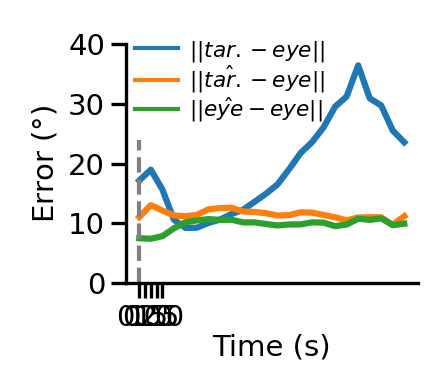

In [14]:
#M53 0.005
area = 'PFC'
width = 1.3; height = 1.1
yticks = np.linspace(0, 40, 5)
xticks = np.linspace(0, 2, 5)
xdata = np.arange(t_total) * DT + 0.051 - 0.4
tmask = xdata > -0.2; xdata = xdata[tmask]
ydata1 = np.array([[np.nanmean(np.sqrt(sess_v[t]['ver_vs_ideal_ver']**2 + sess_v[t]['hor_vs_ideal_hor']**2))
                    for t in range(t_total)] for sess_v in error_data[area].values()])
ymean1 = ydata1.mean(axis=0)[tmask]
ystd1 = ydata1.std(axis=0)[tmask]

ydata2 = np.array([[np.nanmean(np.sqrt(sess_v[t]['ver_vs_decode_tardist']**2 + sess_v[t]['hor_vs_decode_tarang']**2))
                    for t in range(t_total)] for sess_v in error_data[area].values()])
ymean2 = ydata2.mean(axis=0)[tmask]
ystd2 = ydata2.std(axis=0)[tmask]

ydata3 = np.array([[np.nanmean(np.sqrt(sess_v[t]['ver_vs_decode_ver']**2 + sess_v[t]['hor_vs_decode_hor']**2))
                    for t in range(t_total)] for sess_v in error_data[area].values()])
ymean3 = ydata3.mean(axis=0)[tmask]
ystd3 = ydata3.std(axis=0)[tmask]

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
#ax.set_title('Horizontal', fontsize=fontsize, fontweight='bold', pad=3)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Error ($\degree$)', fontsize=fontsize)
ax.set_xlabel('Time (s)', fontsize=fontsize)
# ax.set_xlim(0, 2)
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.21)
ax.yaxis.set_label_coords(-0.23, 0.5)
ax.tick_params(axis='both', which='major', pad=1.5)

ax.plot(xdata, ymean1, lw=lw, c='C0', label='$||tar.-eye||$', alpha=1)
ax.plot(xdata, ymean2, lw=lw, c='C1', label='$||\hat{tar.}-eye||$', alpha=1)
ax.plot(xdata, ymean3, lw=lw, c='C2', label='$||\hat{eye}-eye||$', alpha=1)

plt.plot(ydata1.T)
plt.plot(ydata2.T)
plt.plot(ydata3.T)



ax.fill_between(xdata, ymean1 - ystd1, ymean1 + ystd1, facecolor='C0', alpha=0.3)
ax.fill_between(xdata, ymean2 - ystd2, ymean2 + ystd2, facecolor='C1', alpha=0.3)
ax.fill_between(xdata, ymean3 - ystd3, ymean3 + ystd3, facecolor='C2', alpha=0.3)

ax.plot(np.linspace(0, 0), np.linspace(*np.array(ax.get_ylim()) * 0.6), lw=lw, c='gray', ls='--')

ax.legend(fontsize=fontsize-1.8, frameon=False, 
          loc=[0, 0.63], handletextpad=0.5, labelspacing=0, ncol=1, columnspacing=0)
#ax.text(0.02, 15, 'target\noff', fontsize=fontsize-1.5, c='gray')
    
fig.tight_layout(pad=0, rect=[0., 0, 1., 1])


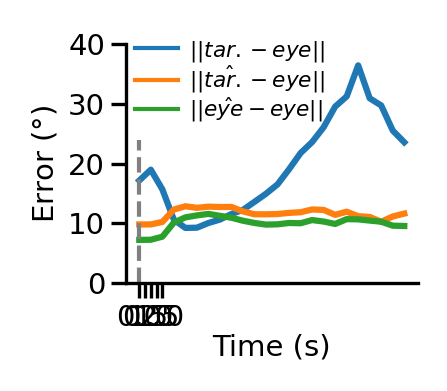

In [15]:
#M53 0.005
area = 'PPC'
width = 1.3; height = 1.1
yticks = np.linspace(0, 40, 5)
xticks = np.linspace(0, 2, 5)
xdata = np.arange(t_total) * DT + 0.051 - 0.4
tmask = xdata > -0.2; xdata = xdata[tmask]
ydata1 = np.array([[np.nanmean(np.sqrt(sess_v[t]['ver_vs_ideal_ver']**2 + sess_v[t]['hor_vs_ideal_hor']**2))
                    for t in range(t_total)] for sess_v in error_data[area].values()])
ymean1 = ydata1.mean(axis=0)[tmask]
ystd1 = ydata1.std(axis=0)[tmask]

ydata2 = np.array([[np.nanmean(np.sqrt(sess_v[t]['ver_vs_decode_tardist']**2 + sess_v[t]['hor_vs_decode_tarang']**2))
                    for t in range(t_total)] for sess_v in error_data[area].values()])
ymean2 = ydata2.mean(axis=0)[tmask]
ystd2 = ydata2.std(axis=0)[tmask]

ydata3 = np.array([[np.nanmean(np.sqrt(sess_v[t]['ver_vs_decode_ver']**2 + sess_v[t]['hor_vs_decode_hor']**2))
                    for t in range(t_total)] for sess_v in error_data[area].values()])
ymean3 = ydata3.mean(axis=0)[tmask]
ystd3 = ydata3.std(axis=0)[tmask]

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
#ax.set_title('Horizontal', fontsize=fontsize, fontweight='bold', pad=3)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Error ($\degree$)', fontsize=fontsize)
ax.set_xlabel('Time (s)', fontsize=fontsize)
# ax.set_xlim(0, 2)
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.21)
ax.yaxis.set_label_coords(-0.23, 0.5)
ax.tick_params(axis='both', which='major', pad=1.5)

ax.plot(xdata, ymean1, lw=lw, c='C0', label='$||tar.-eye||$', alpha=1)
ax.plot(xdata, ymean2, lw=lw, c='C1', label='$||\hat{tar.}-eye||$', alpha=1)
ax.plot(xdata, ymean3, lw=lw, c='C2', label='$||\hat{eye}-eye||$', alpha=1)

plt.plot(ydata1.T)
plt.plot(ydata2.T)
plt.plot(ydata3.T)



ax.fill_between(xdata, ymean1 - ystd1, ymean1 + ystd1, facecolor='C0', alpha=0.3)
ax.fill_between(xdata, ymean2 - ystd2, ymean2 + ystd2, facecolor='C1', alpha=0.3)
ax.fill_between(xdata, ymean3 - ystd3, ymean3 + ystd3, facecolor='C2', alpha=0.3)

ax.plot(np.linspace(0, 0), np.linspace(*np.array(ax.get_ylim()) * 0.6), lw=lw, c='gray', ls='--')

ax.legend(fontsize=fontsize-1.8, frameon=False, 
          loc=[0, 0.63], handletextpad=0.5, labelspacing=0, ncol=1, columnspacing=0)
#ax.text(0.02, 15, 'target\noff', fontsize=fontsize-1.5, c='gray')
    
fig.tight_layout(pad=0, rect=[0., 0, 1., 1])


# example corr

In [16]:
# helper functions

def compute_corr(data1, data2, mask):
    data1 = data1[~mask]; data2 = data2[~mask]
    corr = np.corrcoef(data1, data2)
    return abs(corr[0, 1])
def compute_partial_corr(data1, data2, data3, mask):
    data1 = data1[~mask]; data2 = data2[~mask]; data3 = data3[~mask]    
    df = pd.DataFrame({'d1': data1, 'd2': data2, 'd3': data3})
    corr_partial = partial_corr(data=df, x='d1', y='d2', covar='d3')['r'].item()
    return abs(corr_partial)

def shuffle_decoder(seed):
    kf = KFold(n_splits=5)
    decoded_target_idx = [4, 5, 6, 7]
    m_decoders = {}
    for area in areas:  # loop areas
        decoders_session = {}
        for key in eval(m).keys():  # loop sessions
            if key[-1].isalpha():
                continue

            X = eval(m)[key + 'Xdownsampled'][area]
            if len(X) == 0:
                continue
            Y = eval(m)[key + 'Ydownsampled']
            trial_idces, X = zip(*X)
            trial_idces, Y = zip(*Y); trial_idces = np.array(trial_idces)

            model_variable = []
            for idx_variable in decoded_target_idx:  # loop target variable
                model_kfold = []
                for train_trial_idx, test_trial_idx in kf.split(trial_idces):  # loop K fold
                    X_train = np.concatenate([X[i] for i in train_trial_idx]) 
                    X_test = np.concatenate([X[i] for i in test_trial_idx])
                    Y_train = np.concatenate([Y[i] for i in train_trial_idx])
                    Y_test = np.concatenate([Y[i] for i in test_trial_idx])

                    train_mask = ~np.isnan(Y_train[:, idx_variable])
                    test_mask = ~np.isnan(Y_test[:, idx_variable])

                    #shuffle
                    rng = np.random.default_rng(seed=seed)
                    shifts = rng.integers(1, X_train.shape[0], size=X_train.shape[1])
                    for i, shift in enumerate(shifts):
                        X_train[:, i] = np.roll(X_train[:, i], shift=shift)

                    pipe = make_pipeline(StandardScaler(), RidgeCV())
                    pipe.fit(X_train[train_mask], Y_train[train_mask, idx_variable])

                    model_kfold.append([test_trial_idx, trial_idces[test_trial_idx], pipe])

                model_variable.append(model_kfold)
            decoders_session[key] = model_variable
        m_decoders[area + 'decoder'] = decoders_session


    m_score_t = {}
    for area in areas:
        scores_error_session_by_trial = {}
        for key in eval(m).keys():
            if key[-1].isalpha():
                continue

            Xt = eval(m)[key + 'Xt'][area]
            if len(Xt[0]) == 0:
                continue
            Yt = eval(m)[key + 'Yt']
            scores_trial = []

            for t in range(num_bins):
                trial_idces, X = zip(*Xt[t])
                X = np.vstack(X)
                trial_idces, Y = zip(*Yt[t])
                Y = np.vstack(Y)

                # decoding
                score_trial = []
                for idx_variable_enu, idx_variable in enumerate(decoded_target_idx):
                    Y_ = Y[:, idx_variable]
                    score_trial_ = []
                    for kfold_trial_indices, kfold_trial_relindices, kfold_decoder in \
                                                                        m_decoders[area + 'decoder'][key][idx_variable_enu]:
                        # decoding error for each trial
                        for trial_idx_enu, trial_idx in enumerate(trial_idces):
                            if trial_idx not in kfold_trial_relindices:
                                continue
                            score_trial_.append([trial_idx, t, 
                                                 kfold_decoder.predict(X[trial_idx_enu:trial_idx_enu+1])[0], 
                                                 Y_[trial_idx_enu:trial_idx_enu+1][0]])

                    score_trial.append(score_trial_)
                scores_trial.append(np.array(score_trial))  
            scores_error_session_by_trial[key] = np.concatenate(scores_trial, axis=1).swapaxes(0, 2)
        m_score_t[area + 'decoding_error_trial'] = scores_error_session_by_trial
    return m_score_t

In [17]:
# calculate the correlation

correlation_data = {}
for area in ['PPC', 'MST', 'PFC']:      
    correlation_data_session = {}
    for key in eval(m)[f'{area}tracking_error_trial'].keys():  # loop sessions
        correlation_data_ = {}
        tracking_data = eval(m)[f'{area}tracking_error_trial'][key]
        decoder_true_data = eval(m)[f'{area}decoding_error_trial'][key][3]
        decoder_predicted_data = eval(m)[f'{area}decoding_error_trial'][key][2]
        decoding_error_data = decoder_predicted_data - decoder_true_data
        steer_error_data = eval(m)[key + 'error_sign']
        target_angle_data = np.array(eval(m)[key + 'target_angle'])
        target_distance_data = np.array(eval(m)[key + 'target_distance'])
        
        decode_reldist = decoder_predicted_data[:, 7]
        decode_relang = decoder_predicted_data[:, 6]

        decode_eye_hor = decoder_predicted_data[:, 4]
        decode_eye_ver = decoder_predicted_data[:, 5]

        eye_positions_hor = decoder_true_data[:, 4]
        eye_positions_ideal_hor = decoder_true_data[:, 6]
        eye_positions_ver = decoder_true_data[:, 5]
        eye_positions_ideal_ver = decoder_true_data[:, 7]
        
        mask = np.isnan(eye_positions_ideal_hor) | np.isnan(eye_positions_ideal_ver)
        
        correlation_data_['hor_vs_ideal_hor'] = compute_corr(eye_positions_hor, eye_positions_ideal_hor, mask)
        correlation_data_['ver_vs_ideal_ver'] = compute_corr(eye_positions_ver, eye_positions_ideal_ver, mask)
        
        correlation_data_['hor_vs_decode_tarang'] = compute_corr(eye_positions_hor, decode_relang, mask)
        correlation_data_['ver_vs_decode_tardist'] = compute_corr(eye_positions_ver, decode_reldist, mask)
        correlation_data_['hor_vs_decode_tarang_partial'] = compute_partial_corr(eye_positions_hor, decode_relang, 
                                                                                 eye_positions_ideal_hor, mask)
        correlation_data_['ver_vs_decode_tardist_partial'] = compute_partial_corr(eye_positions_ver, decode_reldist, 
                                                                                  eye_positions_ideal_ver, mask)
        
        correlation_data_['tarang_vs_decode_hor'] = compute_corr(eye_positions_ideal_hor, decode_eye_hor, mask)
        correlation_data_['tardist_vs_decode_ver'] = compute_corr(eye_positions_ideal_ver, decode_eye_ver, mask)
        correlation_data_['tarang_vs_decode_hor_partial'] = compute_partial_corr(eye_positions_ideal_hor, decode_eye_hor, 
                                                                                 eye_positions_hor, mask)
        correlation_data_['tardist_vs_decode_ver_partial'] = compute_partial_corr(eye_positions_ideal_ver, decode_eye_ver, 
                                                                                  eye_positions_ver, mask)
        
        correlation_data_['tarang_vs_decode_tarang'] = compute_corr(eye_positions_ideal_hor, decode_relang, mask)
        correlation_data_['tardist_vs_decode_tardist'] = compute_corr(eye_positions_ideal_ver, decode_reldist, mask)
        correlation_data_['tarang_vs_decode_tarang_partial'] = compute_partial_corr(eye_positions_ideal_hor, 
                                                                                    decode_relang, eye_positions_hor, mask)
        correlation_data_['tardist_vs_decode_tardist_partial'] = compute_partial_corr(eye_positions_ideal_ver, 
                                                                                      decode_reldist, 
                                                                                      eye_positions_ver, mask)
        
        correlation_data_['hor_vs_decode_hor'] = compute_corr(eye_positions_hor, decode_eye_hor, mask)
        correlation_data_['ver_vs_decode_ver'] = compute_corr(eye_positions_ver, decode_eye_ver, mask)
        correlation_data_['hor_vs_decode_hor_partial'] = compute_partial_corr(eye_positions_hor, decode_eye_hor, 
                                                                              eye_positions_ideal_hor, mask)
        correlation_data_['ver_vs_decode_ver_partial'] = compute_partial_corr(eye_positions_ver, decode_eye_ver, 
                                                                              eye_positions_ideal_ver, mask)
        
        correlation_data_['decode_hor_vs_decode_tarang'] = compute_corr(decode_eye_hor, decode_relang, mask)
        correlation_data_['decode_ver_vs_decode_tardist'] = compute_corr(decode_eye_ver, decode_reldist, mask)
                
        correlation_data_session[key] = correlation_data_
    correlation_data[area] = correlation_data_session


hor_vs_ideal_hor_PPC = [v['hor_vs_ideal_hor'] for v in correlation_data['PPC'].values()]
ver_vs_ideal_ver_PPC = [v['ver_vs_ideal_ver'] for v in correlation_data['PPC'].values()]
hor_vs_decode_tarang_PPC = [v['hor_vs_decode_tarang'] for v in correlation_data['PPC'].values()]
ver_vs_decode_tardist_PPC = [v['ver_vs_decode_tardist'] for v in correlation_data['PPC'].values()]
hor_vs_decode_tarang_partial_PPC = [v['hor_vs_decode_tarang_partial'] for v in correlation_data['PPC'].values()]
ver_vs_decode_tardist_partial_PPC = [v['ver_vs_decode_tardist_partial'] for v in correlation_data['PPC'].values()]
tarang_vs_decode_hor_PPC = [v['tarang_vs_decode_hor'] for v in correlation_data['PPC'].values()]
tardist_vs_decode_ver_PPC = [v['tardist_vs_decode_ver'] for v in correlation_data['PPC'].values()]
tarang_vs_decode_hor_partial_PPC = [v['tarang_vs_decode_hor_partial'] for v in correlation_data['PPC'].values()]
tardist_vs_decode_ver_partial_PPC = [v['tardist_vs_decode_ver_partial'] for v in correlation_data['PPC'].values()]
tarang_vs_decode_tarang_PPC = [v['tarang_vs_decode_tarang'] for v in correlation_data['PPC'].values()]
tardist_vs_decode_tardist_PPC = [v['tardist_vs_decode_tardist'] for v in correlation_data['PPC'].values()]
tarang_vs_decode_tarang_partial_PPC = [v['tarang_vs_decode_tarang_partial'] for v in correlation_data['PPC'].values()]
tardist_vs_decode_tardist_partial_PPC = [v['tardist_vs_decode_tardist_partial'] for v in correlation_data['PPC'].values()]
hor_vs_decode_hor_PPC = [v['hor_vs_decode_hor'] for v in correlation_data['PPC'].values()]
ver_vs_decode_ver_PPC = [v['ver_vs_decode_ver'] for v in correlation_data['PPC'].values()]
hor_vs_decode_hor_partial_PPC = [v['hor_vs_decode_hor_partial'] for v in correlation_data['PPC'].values()]
ver_vs_decode_ver_partial_PPC = [v['ver_vs_decode_ver_partial'] for v in correlation_data['PPC'].values()]
decode_hor_vs_decode_tarang_PPC = [v['decode_hor_vs_decode_tarang'] for v in correlation_data['PPC'].values()]
decode_ver_vs_decode_tardist_PPC = [v['decode_ver_vs_decode_tardist'] for v in correlation_data['PPC'].values()]


hor_vs_ideal_hor_MST = [v['hor_vs_ideal_hor'] for v in correlation_data['MST'].values()]
ver_vs_ideal_ver_MST = [v['ver_vs_ideal_ver'] for v in correlation_data['MST'].values()]
hor_vs_decode_tarang_MST = [v['hor_vs_decode_tarang'] for v in correlation_data['MST'].values()]
ver_vs_decode_tardist_MST = [v['ver_vs_decode_tardist'] for v in correlation_data['MST'].values()]
hor_vs_decode_tarang_partial_MST = [v['hor_vs_decode_tarang_partial'] for v in correlation_data['MST'].values()]
ver_vs_decode_tardist_partial_MST = [v['ver_vs_decode_tardist_partial'] for v in correlation_data['MST'].values()]
tarang_vs_decode_hor_MST = [v['tarang_vs_decode_hor'] for v in correlation_data['MST'].values()]
tardist_vs_decode_ver_MST = [v['tardist_vs_decode_ver'] for v in correlation_data['MST'].values()]
tarang_vs_decode_hor_partial_MST = [v['tarang_vs_decode_hor_partial'] for v in correlation_data['MST'].values()]
tardist_vs_decode_ver_partial_MST = [v['tardist_vs_decode_ver_partial'] for v in correlation_data['MST'].values()]
tarang_vs_decode_tarang_MST = [v['tarang_vs_decode_tarang'] for v in correlation_data['MST'].values()]
tardist_vs_decode_tardist_MST = [v['tardist_vs_decode_tardist'] for v in correlation_data['MST'].values()]
tarang_vs_decode_tarang_partial_MST = [v['tarang_vs_decode_tarang_partial'] for v in correlation_data['MST'].values()]
tardist_vs_decode_tardist_partial_MST = [v['tardist_vs_decode_tardist_partial'] for v in correlation_data['MST'].values()]
hor_vs_decode_hor_MST = [v['hor_vs_decode_hor'] for v in correlation_data['MST'].values()]
ver_vs_decode_ver_MST = [v['ver_vs_decode_ver'] for v in correlation_data['MST'].values()]
hor_vs_decode_hor_partial_MST = [v['hor_vs_decode_hor_partial'] for v in correlation_data['MST'].values()]
ver_vs_decode_ver_partial_MST = [v['ver_vs_decode_ver_partial'] for v in correlation_data['MST'].values()]
decode_hor_vs_decode_tarang_MST = [v['decode_hor_vs_decode_tarang'] for v in correlation_data['MST'].values()]
decode_ver_vs_decode_tardist_MST = [v['decode_ver_vs_decode_tardist'] for v in correlation_data['MST'].values()]


hor_vs_ideal_hor_PFC = [v['hor_vs_ideal_hor'] for v in correlation_data['PFC'].values()]
ver_vs_ideal_ver_PFC = [v['ver_vs_ideal_ver'] for v in correlation_data['PFC'].values()]
hor_vs_decode_tarang_PFC = [v['hor_vs_decode_tarang'] for v in correlation_data['PFC'].values()]
ver_vs_decode_tardist_PFC = [v['ver_vs_decode_tardist'] for v in correlation_data['PFC'].values()]
hor_vs_decode_tarang_partial_PFC = [v['hor_vs_decode_tarang_partial'] for v in correlation_data['PFC'].values()]
ver_vs_decode_tardist_partial_PFC = [v['ver_vs_decode_tardist_partial'] for v in correlation_data['PFC'].values()]
tarang_vs_decode_hor_PFC = [v['tarang_vs_decode_hor'] for v in correlation_data['PFC'].values()]
tardist_vs_decode_ver_PFC = [v['tardist_vs_decode_ver'] for v in correlation_data['PFC'].values()]
tarang_vs_decode_hor_partial_PFC = [v['tarang_vs_decode_hor_partial'] for v in correlation_data['PFC'].values()]
tardist_vs_decode_ver_partial_PFC = [v['tardist_vs_decode_ver_partial'] for v in correlation_data['PFC'].values()]
tarang_vs_decode_tarang_PFC = [v['tarang_vs_decode_tarang'] for v in correlation_data['PFC'].values()]
tardist_vs_decode_tardist_PFC = [v['tardist_vs_decode_tardist'] for v in correlation_data['PFC'].values()]
tarang_vs_decode_tarang_partial_PFC = [v['tarang_vs_decode_tarang_partial'] for v in correlation_data['PFC'].values()]
tardist_vs_decode_tardist_partial_PFC = [v['tardist_vs_decode_tardist_partial'] for v in correlation_data['PFC'].values()]
hor_vs_decode_hor_PFC = [v['hor_vs_decode_hor'] for v in correlation_data['PFC'].values()]
ver_vs_decode_ver_PFC = [v['ver_vs_decode_ver'] for v in correlation_data['PFC'].values()]
hor_vs_decode_hor_partial_PFC = [v['hor_vs_decode_hor_partial'] for v in correlation_data['PFC'].values()]
ver_vs_decode_ver_partial_PFC = [v['ver_vs_decode_ver_partial'] for v in correlation_data['PFC'].values()]
decode_hor_vs_decode_tarang_PFC = [v['decode_hor_vs_decode_tarang'] for v in correlation_data['PFC'].values()]
decode_ver_vs_decode_tardist_PFC = [v['decode_ver_vs_decode_tardist'] for v in correlation_data['PFC'].values()]


# load irc belief into the struct

In [18]:
with open(resdir/'neuraltest/res/m53s31_0928newformatbelief', 'rb') as f:
    res = pickle.load(f)


In [19]:
res.keys()

dict_keys(['rad_vel', 'ang_vel', 'x_monk', 'y_monk', 'mask', 'y', 'trial_idx', 'ts', 'covs', 'belief'])

In [40]:
(eval(m)['m53s31Xdownsampled']['PPC'])[1][1].shape

(13, 67)

In [47]:
(eval(m)['m53s31Ydownsampled'])[0][1].shape

(10, 12)

In [41]:
sum(res['trial_idx']==3)


13

we want to shape belief into target variables, trial, [trial id, array]

In [123]:

# i=0
Ydownsampled = [] # belief task variables
trials_error = []; trials_error_sign = []; trials_target_angle = []; trials_target_distance = []

for itrial in np.unique(res['trial_idx'])[:7]:

    # prepare to process time series belief into block per trial
    this_mask=(res['trial_idx']==itrial)
    # print('belief',res['belief'][this_mask].shape)

    # get firefly position from raw data
    trial_behv=trials_behv[itrial]
    trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)
    t_mask = (trial_ts > 0) & (~np.isnan(trial_behv['continuous']['ymp'][0][0].reshape(-1)))
    t_mask &= trial_ts < trial_behv['events']['t_stop'][0][0].reshape(-1)
    if t_mask.sum() > 0:
        t_mask[np.where(t_mask == True)[0][0]] = False # remove the first data point to avoid downsample error
    fx = downsample(trial_behv['continuous']['xfp'][0][0][t_mask],bin_size=bin_size)
    fy = downsample(trial_behv['continuous']['yfp'][0][0][t_mask],bin_size=bin_size)

    # unppack irc belief mu
    mx=res['belief'][this_mask][:,0].reshape(-1,1) # world monkey x (belief)
    my=res['belief'][this_mask][:,1].reshape(-1,1)
    body_theta=res['belief'][this_mask][:,2].reshape(-1,1)
    mv=res['belief'][this_mask][:,3]
    mw=res['belief'][this_mask][:,4]

    # sometimes belief has one more dt due to sampling error. remove the first
    # print('fx', fx.shape)
    # print('mx', mx.shape)
    if len(fx)<len(mx):
        mx=mx[len(mx)-len(fx):]
        my=my[len(my)-len(fy):]
    # print('fx', fx.shape)
    # print('mx', mx.shape)    

    # calculate errors (belief mu)
    sx = np.ones_like(fx); sy = np.ones_like(fy)
    if my.size > 0:
        fx = np.ones_like(fx) * fx[0]
        fy = np.ones_like(fy) * fy[0]
        sx *= mx[-1]; sy *= my[-1]
        my = my + 30; fy = fy + 30; sy = sy + 30
    
    dx = fx - mx; 
    dy = fy - my
    rel_dist = np.sqrt(dx**2 + dy**2); rel_ang = np.rad2deg(np.arctan2(dy, dx))
    rel_dist_stop = np.sqrt((sx - mx)**2 + (sy - my)**2)

    if my.size > 0:
        trials_error.append(rel_dist[-1][0])
        trials_error_sign.append(rel_dist[-1][0])
        trials_target_angle.append(np.rad2deg(np.arctan2(fy, fx))[-1][0] - 90)
        trials_target_distance.append(np.sqrt(fx**2 + fy**2)[-1][0])
        
    else:
        trials_error.append(np.nan)
        trials_error_sign.append(np.nan)
        trials_target_angle.append(np.nan)
        trials_target_distance.append(np.nan)
    
    if my.size > 0:
        d1 = np.sqrt(fx**2 + fy**2)
        r1 = (fx**2 + fy**2) / (2*fx)
        radian1 = 2 * r1 * np.arcsin(d1 / (2 * r1))

        d2 = np.sqrt(mx**2 + my**2)
        r2 = (mx**2 + my**2) / (2*mx + 1e-8)
        radian2 = 2 * r2 * np.arcsin(d2 / (2 * r2 + 1e-8))

        sign = np.ones_like(rel_dist)
        sign[radian2 < radian1] = -1
        rel_dist = sign * rel_dist
        trials_error_sign[-1] = rel_dist[-1][0]
    abs_dist = np.sqrt(mx**2 + my**2); abs_ang = np.rad2deg(np.arctan2(my, mx))

    # calculate relative belief



    # calculate the latent ff position 
    # TODO, this function use eye position. we just want the latent ff positon on screen.
    body_x, body_y = mx.reshape(-1), my.reshape(-1)
    hor_theta_, ver_theta_ = convert_location_to_angle(abs(rel_dist).reshape(-1), fx.reshape(-1), fy.reshape(-1),
                                                    body_theta, body_x, body_y, 
                                                    hor_theta.reshape(-1), ver_theta.reshape(-1))

    # group and save
    target_variable = np.hstack([])



    # print('rel_dist', rel_dist_stop.shape)
    # print('\n')



    # print(eval(m)['m53s31Ydownsampled'][i][0])
    # print('evalm, y',eval(m)['m53s31Ydownsampled'][i][1].shape,'\n')

    # i+=1


rel_dist (10, 1)


rel_dist (13, 1)


rel_dist (12, 1)


rel_dist (36, 1)


rel_dist (11, 1)


rel_dist (24, 1)


rel_dist (15, 1)




In [101]:
for trial_idx, trial_behv in enumerate(trials_behv[:5]):
        # get firefly position
    trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)
    t_mask = (trial_ts > 0) & (~np.isnan(trial_behv['continuous']['ymp'][0][0].reshape(-1)))
    t_mask &= trial_ts < trial_behv['events']['t_stop'][0][0].reshape(-1)
    if t_mask.sum() > 0:
        t_mask[np.where(t_mask == True)[0][0]] = False # remove the first data point to avoid downsample error
    fx = downsample(trial_behv['continuous']['xfp'][0][0][t_mask],bin_size=bin_size)
    fy = downsample(trial_behv['continuous']['yfp'][0][0][t_mask],bin_size=bin_size)

    print('fx',trial_idx, fx.shape)

fx 0 (68, 1)
fx 1 (39, 1)
fx 2 (10, 1)
fx 3 (13, 1)
fx 4 (12, 1)


In [82]:
rel_dist_stop.shape, dx.shape,fx.shape, trial_ts.shape

((10, 12), (10, 12), (10, 1), (640,))

In [ ]:

y_ = res['y']
X_mat = X
X = {k: res[k] for k in ['rad_vel', 'ang_vel', 'x_monk', 'y_monk']}
trial_idx = res['trial_idx']
beliefs = res['belief']
covs = res['covs']
mask = res['mask']
s = np.vstack([v for v in X.values()])
s = s.T